In [ ]:
# Step 1: Import required libraries

from pathlib import Path
import pdfplumber
import re
import pandas as pd

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
# Step 2: Check if the 4 PDF files exist in the same folder as this notebook

from pathlib import Path

BASE = Path(".")  # current directory

PDF_FILES = [
    BASE / "May statement period.pdf",
    BASE / "June statement period.pdf",
    BASE / "July statement period.pdf",
    BASE / "August statement period.pdf"
]

print("📂 Checking for PDF files in the current directory:\n")
for f in PDF_FILES:
    if f.exists():
        print(f"✅ Found: {f.name}")
    else:
        print(f"⚠️ Not found: {f.name}")

📂 Checking for PDF files in the current directory:

✅ Found: May statement period.pdf
✅ Found: June statement period.pdf
✅ Found: July statement period.pdf
✅ Found: August statement period.pdf


In [ ]:
# Step 3: Extract text from all PDF files and collect transactions

transactions = []  # list to store extracted transactions

for pdf_path in PDF_FILES:
    print(f"🔍 Reading file: {pdf_path.name}")
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                lines = text.split("\n")
                for line in lines:
                    # Simple example: capture lines that contain a date pattern (e.g., 12/05/2025)
                    if re.search(r"\d{2}/\d{2}/\d{4}", line):
                        transactions.append(line)

print(f"\n✅ Total extracted lines containing transaction-like data: {len(transactions)}")

🔍 Reading file: May statement period.pdf
🔍 Reading file: June statement period.pdf
🔍 Reading file: July statement period.pdf
🔍 Reading file: August statement period.pdf

✅ Total extracted lines containing transaction-like data: 0


In [ ]:
# Step 4: Preview raw text from the first page of the first PDF

import itertools

pdf_path = PDF_FILES[0]  # use first PDF (May statement)
print(f"📄 Previewing text from: {pdf_path.name}\n")

with pdfplumber.open(pdf_path) as pdf:
    page = pdf.pages[0]
    text = page.extract_text()
    if text:
        lines = text.split("\n")
        # Display first 30 lines only
        for line in itertools.islice(lines, 30):
            print(line)
    else:
        print("⚠️ No text extracted. The PDF may be image-based (scanned).")

📄 Previewing text from: May statement period.pdf

ENOCH A-IYEH
CIBC Dividend® Visa* Card
Account number
4505 5300 3195 4066
May statement period
May 14 to June 13, 2025
Your account at a glance
Contact us
Customer Service 1 800 465-4653
Previous balance $0.00
Lost/Stolen 1 800 663-4575
Payments $5,254.46 TTY 1 877 331-3338
Other credits 0.00 Online www.cibc.com
Total credits - $5,254.46 Summary Credit† Cash†
Purchases 5,254.77
Limit $500.00 $500.00
Cash advances 0.00 Available $499.69 $499.00
Interest 0.00 Interest rates
Annual
Fees 0.00
Regular purchases 19.99%
Total charges + $5,254.77
Cash advances 22.99%
New balance = $0.31
Your minimum payment due Cash Back Summary
As at last statement + 38.02
This statement
Current month’s minimum payment $0.31 2% Cash Back
Please pay this amount by Jun 30, 2025
Cash Back


In [ ]:
# Step 5: Detect and preview candidate transaction lines

import re
import pdfplumber

months = r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)"
# Pattern: Month Day (optional comma and year), some description text, amount at the end (may have $ and commas), optional "CR"
tx_pattern = re.compile(
    rf"^{months}\s+\d{{1,2}}(?:,?\s*\d{{4}})?\s+(.*?)\s+(-?\$?\d[\d,]*\.\d{{2}})\s*(CR)?$"
)

candidates = []

for pdf_path in PDF_FILES:
    with pdfplumber.open(pdf_path) as pdf:
        for pageno, page in enumerate(pdf.pages, start=1):
            text = page.extract_text() or ""
            for i, line in enumerate(text.split("\n"), start=1):
                m = tx_pattern.match(line.strip())
                if m:
                    mon, desc, amt, cr = m.group(1), m.group(2), m.group(3), m.group(4)
                    candidates.append({
                        "file": pdf_path.name,
                        "page": pageno,
                        "line_no": i,
                        "raw_line": line.strip(),
                        "month": mon,
                        "desc": desc.strip(),
                        "amount_raw": (amt + (" CR" if cr else "")),
                    })

print(f"✅ Found {len(candidates)} candidate lines.")
print("\n🔎 First 20 candidates:")
for row in candidates[:20]:
    print(f"- [{row['file']} p{row['page']}#{row['line_no']}] {row['raw_line']}")

✅ Found 34 candidate lines.

🔎 First 20 candidates:
- [May statement period.pdf p2#6] May 16 May 18 PAYMENT THANK YOU/PAIEMENT MERCI 12.38
- [May statement period.pdf p2#7] May 18 May 19 PAYMENT THANK YOU/PAIEMENT MERCI 4,500.00
- [May statement period.pdf p2#8] May 21 May 24 PAYMENT THANK YOU/PAIEMENT MERCI 58.34
- [May statement period.pdf p2#9] May 22 May 25 PAYMENT THANK YOU/PAIEMENT MERCI 630.00
- [May statement period.pdf p2#10] Jun 10 Jun 12 PAYMENT THANK YOU/PAIEMENT MERCI 53.74
- [May statement period.pdf p2#18] May 16 May 17 NORTH GARDEN RESTAURAN WINNIPEG MB Restaurants 12.38
- [May statement period.pdf p2#23] May 19 May 20 NORTH GARDEN RESTAURAN WINNIPEG MB Restaurants 12.38
- [May statement period.pdf p2#30] May 29 Jun 01 Ý REAL CDN. SUPERSTORE # WINNIPEG MB Retail and Grocery 30.90
- [June statement period.pdf p2#6] Jun 13 Jun 16 PAYMENT THANK YOU/PAIEMENT MERCI 0.31
- [June statement period.pdf p2#7] Jun 17 Jun 19 PAYMENT THANK YOU/PAIEMENT MERCI 20.00
- [June statement 

In [ ]:
# Step 6: Convert extracted transactions into a DataFrame

import pandas as pd

# Create DataFrame from candidate transactions
df = pd.DataFrame(candidates)

# Clean amount field
def clean_amount(val):
    val = val.replace("$", "").replace(",", "").replace("CR", "").strip()
    try:
        return float(val)
    except ValueError:
        return None

df["Amount"] = df["amount_raw"].apply(clean_amount)

# Add transaction date column
df["Transaction Date"] = df["month"] + " " + df["desc"].str.extract(r"^(\d{1,2})")[0].fillna("")

# Reorder and select useful columns
df = df[["file", "Transaction Date", "desc", "Amount"]]

# Display first few rows
print("✅ Sample transactions table:")
display(df.head(10))

✅ Sample transactions table:


,file,Transaction Date,desc,Amount
0,May statement period.pdf,May,May 18 PAYMENT THANK YOU/PAIEMENT MERCI,12.38
1,May statement period.pdf,May,May 19 PAYMENT THANK YOU/PAIEMENT MERCI,4500.00
2,May statement period.pdf,May,May 24 PAYMENT THANK YOU/PAIEMENT MERCI,58.34
3,May statement period.pdf,May,May 25 PAYMENT THANK YOU/PAIEMENT MERCI,630.00
4,May statement period.pdf,Jun,Jun 12 PAYMENT THANK YOU/PAIEMENT MERCI,53.74
5,May statement period.pdf,May,May 17 NORTH GARDEN RESTAURAN WINNIPEG MB Rest...,12.38
6,May statement period.pdf,May,May 20 NORTH GARDEN RESTAURAN WINNIPEG MB Rest...,12.38
7,May statement period.pdf,May,Jun 01 Ý REAL CDN. SUPERSTORE # WINNIPEG MB Re...,30.90
8,June statement period.pdf,Jun,Jun 16 PAYMENT THANK YOU/PAIEMENT MERCI,0.31
9,June statement period.pdf,Jun,Jun 19 PAYMENT THANK YOU/PAIEMENT MERCI,20.00


In [ ]:
# Step 7: Export the transaction table to Excel and CSV

# Export to Excel
excel_path = "Transactions_Summary.xlsx"
df.to_excel(excel_path, index=False)

# Export to CSV
csv_path = "Transactions_Summary.csv"
df.to_csv(csv_path, index=False)

print("✅ Data exported successfully!")
print(f"📁 Excel file saved as: {excel_path}")
print(f"📁 CSV file saved as: {csv_path}")

✅ Data exported successfully!
📁 Excel file saved as: Transactions_Summary.xlsx
📁 CSV file saved as: Transactions_Summary.csv


In [ ]:
# Step X: Parse transactions with a template (regex) -> array of dicts, add postdate & category

import re
from datetime import datetime
import pandas as pd

YEAR = 2025  # per assignment

# Keyword-based categorizer
CATEGORY_RULES = [
    (r"PAYMENT|PAIEMENT MERCI", "Payment"),
    (r"SUPERSTORE|WALMART|COSTCO|GROC|MART|SUPERMARKET", "Grocery"),
    (r"RESTAURANT|CAFE|COFFEE|DINER|FOOD|PIZZA|SUSHI|MB Restaurants", "Restaurant"),
    (r"GAS|SHELL|PETRO|ESSO", "Gas"),
    (r"UBI|E-TRANSFER|INTERAC|WIRE|ADVANCE|CASH ADV", "Transfer/Cash"),
    (r"FEE|CHARGE|INTEREST", "Fees/Interest"),
]

def categorize(desc: str) -> str:
    d = desc.upper()
    for pat, cat in CATEGORY_RULES:
        if re.search(pat, d):
            return cat
    return "Other"

# Template (regex) for lines of form:
# "May 18 PAYMENT THANK YOU/PAIEMENT MERCI 12.38"
# Optional postdate at the start of the line: "Jun 01 Jun 03 SOME MERCHANT 30.90"
line_pattern = re.compile(
    r"""^
        (?P<m1>[A-Za-z]{3})\s(?P<d1>\d{1,2})      # transaction month/day
        (?:\s+(?P<m2>[A-Za-z]{3})\s(?P<d2>\d{1,2}))?  # optional post month/day
        \s+(?P<desc>.+?)                           # description (greedy but will be trimmed by amount)
        \s+(?P<amount>-?\d{1,3}(?:,\d{3})*(?:\.\d{2})?)  # amount at end
        (?:\s*CR)?\s*$                             # optional CR
    """,
    re.VERBOSE,
)

# Helper to build ISO date
def make_date(mon_str: str, day_str: str) -> str:
    try:
        dt = datetime.strptime(f"{mon_str} {day_str} {YEAR}", "%b %d %Y")
        return dt.strftime("%Y-%m-%d")
    except Exception:
        return None

records = []  # <-- array of dicts per yêu cầu

for pdf_path in PDF_FILES:
    with pdfplumber.open(pdf_path) as pdf:
        for pidx, page in enumerate(pdf.pages, start=1):
            text = page.extract_text() or ""
            for raw_line in text.splitlines():
                raw_line = raw_line.strip()
                m = line_pattern.match(raw_line)
                if not m:
                    continue

                m1, d1 = m.group("m1"), m.group("d1")
                m2, d2 = m.group("m2"), m.group("d2")
                desc = m.group("desc").strip()
                amt_str = m.group("amount")

                # normalize amount
                amount = float(amt_str.replace(",", ""))

                # dates
                transaction_date = make_date(m1, d1)
                post_date = make_date(m2, d2) if (m2 and d2) else transaction_date  # fallback to same day if missing

                # category
                category = categorize(desc)

                records.append({
                    "file": pdf_path.name,
                    "page": pidx,
                    "transaction_date": transaction_date,
                    "post_date": post_date,
                    "description": desc,
                    "category": category,
                    "amount": amount,
                    "raw_line": raw_line,  # keep raw for traceability
                })

print(f"✅ Parsed {len(records)} transactions into an array of dicts.")
# Peek first 10
pd.DataFrame(records).head(10)

✅ Parsed 34 transactions into an array of dicts.


,file,page,transaction_date,post_date,description,category,amount,raw_line
0,May statement period.pdf,2,2025-05-16,2025-05-18,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,12.38,May 16 May 18 PAYMENT THANK YOU/PAIEMENT MERCI...
1,May statement period.pdf,2,2025-05-18,2025-05-19,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,4500.00,May 18 May 19 PAYMENT THANK YOU/PAIEMENT MERCI...
2,May statement period.pdf,2,2025-05-21,2025-05-24,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,58.34,May 21 May 24 PAYMENT THANK YOU/PAIEMENT MERCI...
3,May statement period.pdf,2,2025-05-22,2025-05-25,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,630.00,May 22 May 25 PAYMENT THANK YOU/PAIEMENT MERCI...
4,May statement period.pdf,2,2025-06-10,2025-06-12,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,53.74,Jun 10 Jun 12 PAYMENT THANK YOU/PAIEMENT MERCI...
5,May statement period.pdf,2,2025-05-16,2025-05-17,NORTH GARDEN RESTAURAN WINNIPEG MB Restaurants,Restaurant,12.38,May 16 May 17 NORTH GARDEN RESTAURAN WINNIPEG ...
6,May statement period.pdf,2,2025-05-19,2025-05-20,NORTH GARDEN RESTAURAN WINNIPEG MB Restaurants,Restaurant,12.38,May 19 May 20 NORTH GARDEN RESTAURAN WINNIPEG ...
7,May statement period.pdf,2,2025-05-29,2025-06-01,Ý REAL CDN. SUPERSTORE # WINNIPEG MB Retail an...,Grocery,30.90,May 29 Jun 01 Ý REAL CDN. SUPERSTORE # WINNIPE...
8,June statement period.pdf,2,2025-06-13,2025-06-16,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,0.31,Jun 13 Jun 16 PAYMENT THANK YOU/PAIEMENT MERCI...
9,June statement period.pdf,2,2025-06-17,2025-06-19,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,20.00,Jun 17 Jun 19 PAYMENT THANK YOU/PAIEMENT MERCI...


In [ ]:
# Save the array of dicts and a CSV table for later use

import json
import pandas as pd

# records is the list[dict] we built
out_json = "Transactions_Structured.json"
out_csv  = "Transactions_Structured.csv"

# JSON (array of dicts)
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

# CSV (nice table)
df_export = pd.DataFrame(records)[
    ["file", "page", "transaction_date", "post_date", "description", "category", "amount"]
]
df_export.to_csv(out_csv, index=False)

print("✅ Saved:")
print(" -", out_json)
print(" -", out_csv)
len(records), df_export.shape

✅ Saved:
 - Transactions_Structured.json
 - Transactions_Structured.csv


(34, (34, 7))

In [ ]:
# ==============================
# Question 1.2 – Step 1: Load data and prepare month labels
# ==============================

import pandas as pd
from pathlib import Path

# 1) Load data (prefer CSV; fallback to JSON if needed)
csv_path  = Path("Transactions_Structured.csv")
json_path = Path("Transactions_Structured.json")

if csv_path.exists():
    df = pd.read_csv(csv_path)
    source_used = csv_path.name
elif json_path.exists():
    df = pd.read_json(json_path)
    source_used = json_path.name
else:
    raise FileNotFoundError(
        "Cannot find Transactions_Structured.csv or Transactions_Structured.json in the current folder."
    )

print(f"✅ Data loaded from: {source_used}")
print(f"Shape: {df.shape}")

# 2) Ensure required columns exist
required_cols = ["transaction_date", "post_date", "description", "category", "amount"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# 3) Parse date columns (coerce errors to NaT so we can spot issues)
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df["post_date"]        = pd.to_datetime(df["post_date"],        errors="coerce")

# 4) Create friendly month label for filtering, e.g., "May 2025"
#    (You can switch to 'post_date' if your assignment requires post date as the month key.)
df["month_label"] = df["transaction_date"].dt.strftime("%B %Y")

# 5) Standardize amount to numeric (if it is not already)
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

# 6) Quick sanity check
print("\n🧭 Unique month labels found:")
print(sorted(df["month_label"].dropna().unique()))

print("\n🔎 Preview (first 5 rows):")
display(df.head(5))

✅ Data loaded from: Transactions_Structured.csv
Shape: (34, 7)

🧭 Unique month labels found:
['August 2025', 'July 2025', 'June 2025', 'May 2025']

🔎 Preview (first 5 rows):


,file,page,transaction_date,post_date,description,category,amount,month_label
0,May statement period.pdf,2,2025-05-16,2025-05-18,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,12.38,May 2025
1,May statement period.pdf,2,2025-05-18,2025-05-19,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,4500.00,May 2025
2,May statement period.pdf,2,2025-05-21,2025-05-24,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,58.34,May 2025
3,May statement period.pdf,2,2025-05-22,2025-05-25,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,630.00,May 2025
4,May statement period.pdf,2,2025-06-10,2025-06-12,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,53.74,June 2025


In [ ]:
# ==============================
# Question 1.2 – Step 2: Month selector + monthly spend report
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Build a sorted month list (chronological) ---
def _month_sort_key(m):
    return pd.to_datetime(m, format="%B %Y", errors="coerce")

month_options = sorted(df["month_label"].dropna().unique(), key=_month_sort_key)

# --- UI widgets ---
month_dd = widgets.Dropdown(
    options=month_options,
    value=month_options[0],
    description="Month:",
    style={"description_width": "80px"},
    layout=widgets.Layout(width="300px")
)

out = widgets.Output()

def render_month(month_label: str):
    """Filter data by month and render a compact report: KPIs, table, and charts."""
    with out:
        clear_output(wait=True)

        # Filter month
        dfm = df[df["month_label"] == month_label].copy()
        if dfm.empty:
            display(pd.DataFrame({"message":[f"No data for {month_label}"]}))
            return

        # ---- KPIs ----
        total_amt   = dfm["amount"].sum(skipna=True)
        n_txn       = len(dfm)
        min_date    = dfm["transaction_date"].min()
        max_date    = dfm["transaction_date"].max()

        print(f"📅 Report for: {month_label}")
        print(f"• Date range: {min_date.date()} → {max_date.date()}")
        print(f"• #Transactions: {n_txn}")
        print(f"• Total spend: ${total_amt:,.2f}")

        # ---- Table (clean columns for viewing) ----
        cols = ["transaction_date", "post_date", "description", "category", "amount"]
        dft = dfm[cols].sort_values("transaction_date")
        display(dft.reset_index(drop=True))

        # ---- Bar chart by category ----
        cat_sum = (
            dfm.groupby("category", dropna=False)["amount"]
               .sum()
               .sort_values(ascending=False)
        )
        if not cat_sum.empty:
            plt.figure(figsize=(8, 4))
            cat_sum.plot(kind="bar")
            plt.title(f"Total Spend by Category — {month_label}")
            plt.xlabel("Category")
            plt.ylabel("Amount ($)")
            plt.grid(True, axis="y", alpha=0.3)
            plt.tight_layout()
            plt.show()

        # ---- Optional: Daily timeline (uncomment to show) ----
        # daily = dfm.groupby(dfm["transaction_date"].dt.date)["amount"].sum()
        # if not daily.empty:
        #     plt.figure(figsize=(8, 3.5))
        #     daily.plot(marker="o")
        #     plt.title(f"Daily Spend — {month_label}")
        #     plt.xlabel("Date")
        #     plt.ylabel("Amount ($)")
        #     plt.grid(True, alpha=0.3)
        #     plt.tight_layout()
        #     plt.show()

def on_select_month(change):
    if change["name"] == "value" and change["new"] is not None:
        render_month(change["new"])

month_dd.observe(on_select_month, names="value")

# Render UI
display(month_dd, out)
render_month(month_dd.value)

Dropdown(description='Month:', layout=Layout(width='300px'), options=('May 2025', 'June 2025', 'July 2025', 'A…

Output()

In [ ]:
# ==============================
# Question 1.2 – Step 3: Export & Top N helpers
# ==============================
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

btn_export_csv   = widgets.Button(description="Export month → CSV",  button_style="success")
btn_export_xlsx  = widgets.Button(description="Export month → Excel", button_style="info")
topn_slider      = widgets.IntSlider(description="Top N:", value=10, min=5, max=30, step=1,
                                     style={"description_width":"60px"}, layout=widgets.Layout(width="260px"))
out2 = widgets.Output()

def _current_month_df():
    # Lấy tháng đang chọn trong dropdown của Step 2
    month_label = month_dd.value
    return df[df["month_label"] == month_label].copy(), month_label

def on_export_csv(_):
    d, mlabel = _current_month_df()
    fn = f"{mlabel.replace(' ', '_')}_report.csv"
    d.to_csv(fn, index=False)
    with out2:
        out2.clear_output(wait=True)
        print(f"✅ Exported CSV: {fn} ({len(d)} rows)")

def on_export_xlsx(_):
    d, mlabel = _current_month_df()
    fn = f"{mlabel.replace(' ', '_')}_report.xlsx"
    with pd.ExcelWriter(fn, engine="xlsxwriter") as writer:
        d.to_excel(writer, index=False, sheet_name="Transactions")
        # thêm pivot theo category cho đẹp
        (d.pivot_table(index="category", values="amount", aggfunc="sum")
           .sort_values("amount", ascending=False)
           .to_excel(writer, sheet_name="ByCategory"))
    with out2:
        out2.clear_output(wait=True)
        print(f"✅ Exported Excel: {fn} (sheet: Transactions, ByCategory)")

def show_topn(_=None):
    d, mlabel = _current_month_df()
    topn = min(topn_slider.value, len(d))
    d2 = d.sort_values("amount", ascending=False).head(topn)[
        ["transaction_date","post_date","description","category","amount"]
    ]
    with out2:
        out2.clear_output(wait=True)
        print(f"🔝 Top {topn} transactions — {mlabel}")
        display(d2.reset_index(drop=True))

btn_export_csv.on_click(on_export_csv)
btn_export_xlsx.on_click(on_export_xlsx)
topn_slider.observe(show_topn, names="value")

display(widgets.HBox([btn_export_csv, btn_export_xlsx, topn_slider]))
display(out2)
show_topn()

Output()

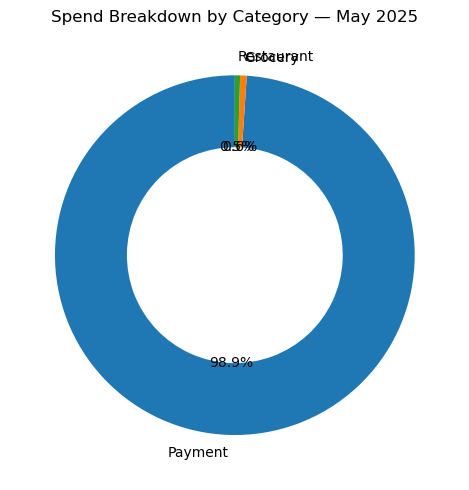

In [ ]:
# ==============================
# Question 1.2 – Step 5: Donut chart by category (for selected month)
# ==============================
import matplotlib.pyplot as plt

def plot_donut(month_label):
    dfm = df[df["month_label"] == month_label].copy()
    if dfm.empty:
        print(f"No data for {month_label}")
        return

    cat_sum = (
        dfm.groupby("category", dropna=False)["amount"]
           .sum()
           .sort_values(ascending=False)
    )

    if cat_sum.empty:
        print(f"No category data for {month_label}")
        return

    # Draw donut
    plt.figure(figsize=(5, 5))
    wedges, texts, autotexts = plt.pie(
        cat_sum,
        labels=cat_sum.index,
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops=dict(width=0.4)
    )
    plt.title(f"Spend Breakdown by Category — {month_label}")
    plt.tight_layout()
    plt.show()

# Tự động vẽ donut cho tháng đang chọn
plot_donut(month_dd.value)

In [ ]:
# ================================
# Question 1.3 — Step 1 (verified version)
# Load and clean data before regression
# ================================

import pandas as pd
from pathlib import Path

csv_path = Path("Transactions_Structured.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"❌ CSV not found: {csv_path.resolve()}")

df = pd.read_csv(csv_path)

# Chuẩn hóa tên cột
df.columns = df.columns.str.strip().str.lower()

print("🧩 Columns loaded:", df.columns.tolist())

# Ép kiểu ngày và amount
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df["post_date"] = pd.to_datetime(df["post_date"], errors="coerce")
df["amount"] = (
    df["amount"].astype(str)
    .str.replace(r"[^0-9.\-]", "", regex=True)
    .replace("", "0")
    .astype(float)
)

# Thêm month_label nếu thiếu
if "month_label" not in df.columns:
    df["month_label"] = df["transaction_date"].dt.strftime("%B %Y")

# Loại bỏ dòng không hợp lệ
before = len(df)
df = df.dropna(subset=["transaction_date","post_date","description","category","amount"]).reset_index(drop=True)
after = len(df)

# In ra thông tin
print(f"\n✅ Loaded rows: {before} → usable: {after}")
print("📅 Unique months:", sorted(df["month_label"].unique().tolist()))
print("\n🔍 First 5 rows:")
display(df.head())

print("\n🧾 Shape:", df.shape)
print("Nulls by column:")
print(df.isna().sum())
print("\n✅ Step 1 completed — data is clean and ready for feature engineering.")

🧩 Columns loaded: ['file', 'page', 'transaction_date', 'post_date', 'description', 'category', 'amount']

✅ Loaded rows: 34 → usable: 34
📅 Unique months: ['August 2025', 'July 2025', 'June 2025', 'May 2025']

🔍 First 5 rows:


,file,page,transaction_date,post_date,description,category,amount,month_label
0,May statement period.pdf,2,2025-05-16,2025-05-18,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,12.38,May 2025
1,May statement period.pdf,2,2025-05-18,2025-05-19,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,4500.00,May 2025
2,May statement period.pdf,2,2025-05-21,2025-05-24,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,58.34,May 2025
3,May statement period.pdf,2,2025-05-22,2025-05-25,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,630.00,May 2025
4,May statement period.pdf,2,2025-06-10,2025-06-12,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,53.74,June 2025



🧾 Shape: (34, 8)
Nulls by column:
file                0
page                0
transaction_date    0
post_date           0
description         0
category            0
amount              0
month_label         0
dtype: int64

✅ Step 1 completed — data is clean and ready for feature engineering.


In [ ]:
# ================================
# Question 1.3 — Step 2
# Feature Engineering & Split Train/Test
# ================================

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Work on a copy
df_m = df.copy()

# Convert date columns to numeric (ordinal)
df_m["transaction_ordinal"] = pd.to_datetime(df_m["transaction_date"]).map(pd.Timestamp.toordinal)
df_m["post_ordinal"]        = pd.to_datetime(df_m["post_date"]).map(pd.Timestamp.toordinal)

# Create lag_days feature (difference between post and transaction date)
df_m["lag_days"] = (df_m["post_date"] - df_m["transaction_date"]).dt.days.clip(lower=0)

# Encode categorical columns
cat_cols = ["description", "category", "month_label"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_m[col] = le.fit_transform(df_m[col].astype(str))
    encoders[col] = le

# Define feature set (X) and target (y)
X = df_m[["page", "transaction_ordinal", "post_ordinal", "lag_days", "description", "category", "month_label"]]
y = df_m["amount"]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Step 2 completed — features and target ready for modeling.")
print("Training shape:", X_train.shape, " | Test shape:", X_test.shape)
display(X_train.head())

✅ Step 2 completed — features and target ready for modeling.
Training shape: (27, 7)  | Test shape: (7, 7)


,page,transaction_ordinal,post_ordinal,lag_days,description,category,month_label
12,2,739432,739434,2,6,3,2
32,2,739485,739487,2,11,1,0
9,2,739419,739421,2,6,3,2
0,2,739387,739389,2,6,3,3
4,2,739412,739414,2,6,3,2


In [ ]:
# ================================
# Question 1.3 — Step 3
# Regression Model: Predict total spend per transaction
# ================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize model
model = RandomForestRegressor(
    n_estimators=200,      # số lượng cây
    max_depth=6,           # giới hạn độ sâu để tránh overfitting
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Step 3 completed — Model trained and evaluated.")
print(f"📊 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.3f}")

# Display comparison of actual vs predicted
import pandas as pd
compare_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
}).reset_index(drop=True)

print("\n🔍 Sample of predictions:")
display(compare_df.head())

✅ Step 3 completed — Model trained and evaluated.
📊 MAE: 356.18
📉 RMSE: 536.78
📈 R² Score: -0.228

🔍 Sample of predictions:


,Actual,Predicted
0,48.00,56.196629
1,1200.00,170.531862
2,1.96,63.841450
3,1.96,63.841450
4,0.31,209.391471


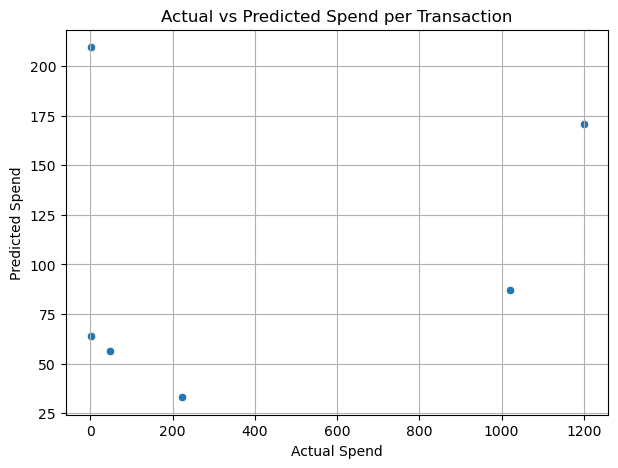

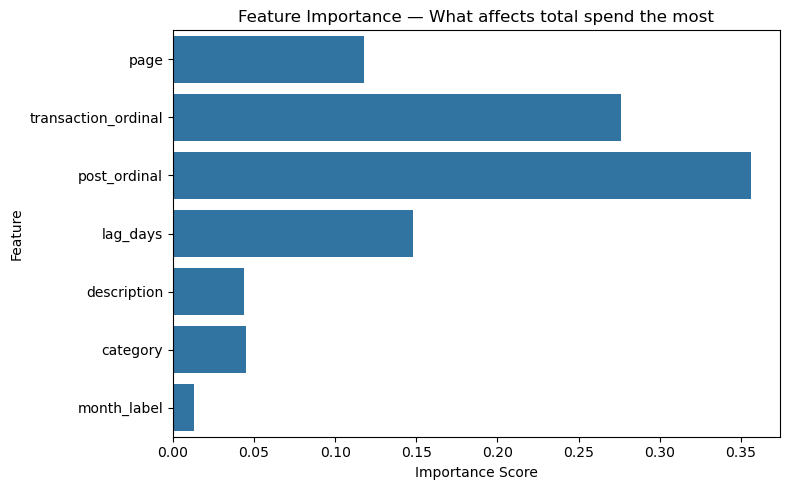

In [ ]:
# ================================
# Question 1.3 — Step 4 (optional)
# Visualization and Insights
# ================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Plot Actual vs Predicted
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Spend")
plt.ylabel("Predicted Spend")
plt.title("Actual vs Predicted Spend per Transaction")
plt.grid(True)
plt.show()

# 2️⃣ Feature importance from Random Forest
importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance — What affects total spend the most")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# ================================
# Question 1.4 — Step 1
# Prepare data for classification model
# ================================

import pandas as pd
from sklearn.model_selection import train_test_split

# Use the same cleaned dataframe (df) from previous steps
df_c = df.copy()

# Keep only necessary columns
df_c = df_c[["description", "category"]].dropna().reset_index(drop=True)

# Encode category labels
from sklearn.preprocessing import LabelEncoder
le_cat = LabelEncoder()
df_c["category_encoded"] = le_cat.fit_transform(df_c["category"])

# Show mapping for clarity
cat_map = dict(zip(le_cat.classes_, le_cat.transform(le_cat.classes_)))
print("✅ Step 1 completed — Data prepared for classification model.\n")
print("📋 Category encoding map:", cat_map)
print("\n🧾 Sample data:")
display(df_c.head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_c["description"], df_c["category_encoded"], test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train)} | Test samples: {len(X_test)}")

✅ Step 1 completed — Data prepared for classification model.

📋 Category encoding map: {'Gas': np.int64(0), 'Grocery': np.int64(1), 'Other': np.int64(2), 'Payment': np.int64(3), 'Restaurant': np.int64(4), 'Transfer/Cash': np.int64(5)}

🧾 Sample data:


,description,category,category_encoded
0,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,3
1,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,3
2,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,3
3,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,3
4,PAYMENT THANK YOU/PAIEMENT MERCI,Payment,3



Training samples: 27 | Test samples: 7


✅ Step 2 completed — Classification model trained.
📊 Accuracy: 0.71

🔍 Classification Report:

              precision    recall  f1-score   support

       Other       1.00      1.00      1.00         1
     Payment       1.00      1.00      1.00         4
  Restaurant       0.00      0.00      0.00         2

   micro avg       1.00      0.71      0.83         7
   macro avg       0.67      0.67      0.67         7
weighted avg       0.71      0.71      0.71         7



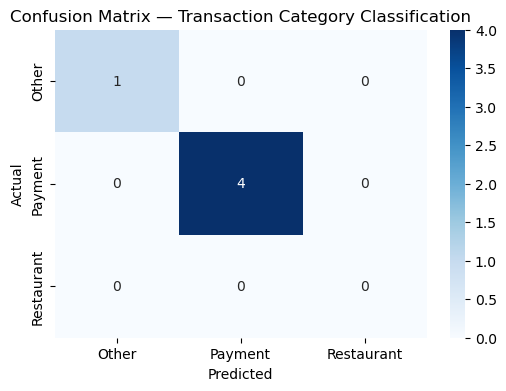

In [ ]:
# ================================
# Question 1.4 — Step 2 (Fixed)
# ================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Convert text to numerical features
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 2️⃣ Train Logistic Regression model
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_tfidf, y_train)

# 3️⃣ Predict
y_pred = clf.predict(X_test_tfidf)

# 4️⃣ Evaluate performance
acc = accuracy_score(y_test, y_pred)
print(f"✅ Step 2 completed — Classification model trained.")
print(f"📊 Accuracy: {acc:.2f}\n")

# ✅ FIX: only include labels that exist in y_test
unique_labels = np.unique(y_test)
target_names = le_cat.inverse_transform(unique_labels)

print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

# 5️⃣ Confusion Matrix visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=unique_labels), annot=True, fmt="d",
            xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Transaction Category Classification")
plt.show()

✅ Step 3 completed — Prediction demo ready.

🔮 Predicted categories for new transactions:
- WALMART SUPERCENTER PURCHASE → Payment
- SHELL GAS STATION → Payment
- STARBUCKS COFFEE TORONTO → Payment
- INTERAC E-TRANSFER TO JOHN DOE → Payment
- PAYMENT THANK YOU/PAIEMENT MERCI → Payment


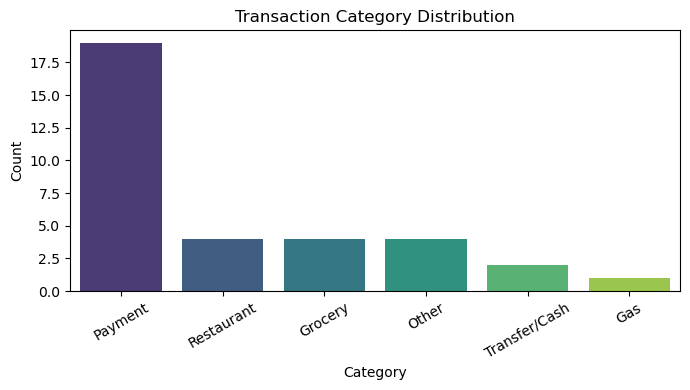

In [ ]:
# ================================
# Question 1.4 — Step 3
# Prediction demo + Visualization
# ================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Predict category for new transaction descriptions
new_transactions = [
    "WALMART SUPERCENTER PURCHASE",
    "SHELL GAS STATION",
    "STARBUCKS COFFEE TORONTO",
    "INTERAC E-TRANSFER TO JOHN DOE",
    "PAYMENT THANK YOU/PAIEMENT MERCI"
]

# Transform text using the same TF-IDF vectorizer
new_tfidf = vectorizer.transform(new_transactions)

# Predict category
new_preds = clf.predict(new_tfidf)
new_categories = le_cat.inverse_transform(new_preds)

# Display results
print("✅ Step 3 completed — Prediction demo ready.\n")
print("🔮 Predicted categories for new transactions:")
for desc, cat in zip(new_transactions, new_categories):
    print(f"- {desc} → {cat}")

# 2️⃣ Visualization: Category distribution in dataset
plt.figure(figsize=(7,4))
sns.countplot(data=df_c, x="category", order=df_c["category"].value_counts().index, palette="viridis")
plt.title("Transaction Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# ======================================
# Question 1.5 — Step 1
# Use all features (encoded where needed)
# ======================================

from sklearn.preprocessing import LabelEncoder

df_all = df.copy()

# 1️⃣ Encode non-numerical columns
cat_cols = ["description", "category", "month_label"]
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))
    encoders[col] = le

# 2️⃣ Define features (X) and target (y)
X = df_all.drop(columns=["amount"])  # all except target
y = df_all["amount"]

# 3️⃣ Check
print("✅ Step 1 completed — All features encoded and ready.")
print("Feature columns:", X.columns.tolist())
print("Shape:", X.shape)
display(df_all.head())

✅ Step 1 completed — All features encoded and ready.
Feature columns: ['file', 'page', 'transaction_date', 'post_date', 'description', 'category', 'month_label']
Shape: (34, 7)


,file,page,transaction_date,post_date,description,category,amount,month_label
0,May statement period.pdf,2,2025-05-16,2025-05-18,6,3,12.38,3
1,May statement period.pdf,2,2025-05-18,2025-05-19,6,3,4500.00,3
2,May statement period.pdf,2,2025-05-21,2025-05-24,6,3,58.34,3
3,May statement period.pdf,2,2025-05-22,2025-05-25,6,3,630.00,3
4,May statement period.pdf,2,2025-06-10,2025-06-12,6,3,53.74,2


Non-numeric columns (should be empty): []

✅ Step 2 completed — Regression model trained using ALL features.
MAE : 336.29
RMSE: 425.84
R²  : 0.227


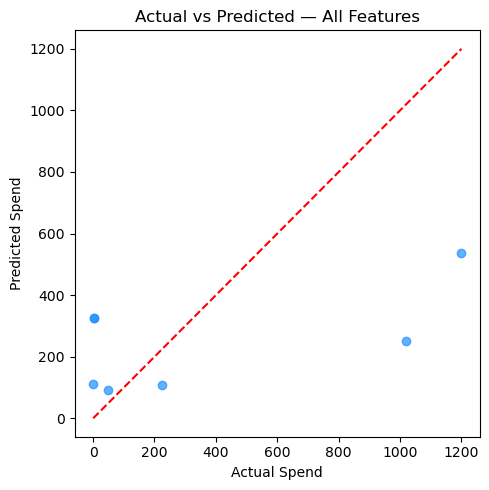

In [ ]:
# ======================================
# Question 1.5 — Step 2 (fix fit error)
# Train regression model using ALL features (after encoding)
# ======================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1) Work on a copy
df_all = df.copy()

# 2) Convert date columns to numeric (ordinal)
for col in ["transaction_date", "post_date"]:
    df_all[col] = pd.to_datetime(df_all[col], errors="coerce").map(lambda x: x.toordinal())

# 3) Encode ALL remaining non-numeric string columns
#    (include 'file', 'description', 'category', 'month_label')
cat_cols = ["file", "description", "category", "month_label"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))
    encoders[col] = le

# 4) Build X, y
X = df_all.drop(columns=["amount"])   # all features except target
y = df_all["amount"]

# 5) Safety check: ensure everything in X is numeric
non_numeric_cols = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
print("Non-numeric columns (should be empty):", non_numeric_cols)

# 6) Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7) Train model
model_all = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=6
)
model_all.fit(X_train, y_train)

# 8) Predict + evaluate
y_pred = model_all.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ Step 2 completed — Regression model trained using ALL features.")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

# 9) Plot Actual vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, color="dodgerblue", alpha=0.7)
mn = min(y_test.min(), y_pred.min())
mx = max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual Spend")
plt.ylabel("Predicted Spend")
plt.title("Actual vs Predicted — All Features")
plt.tight_layout()
plt.show()

✅ Step 3 completed — Comparison between models:



,Model,MAE,RMSE,R²
0,Regression (1.3),356.18,536.78,-0.228
1,Regression + All Features (1.5),336.29,425.84,0.227


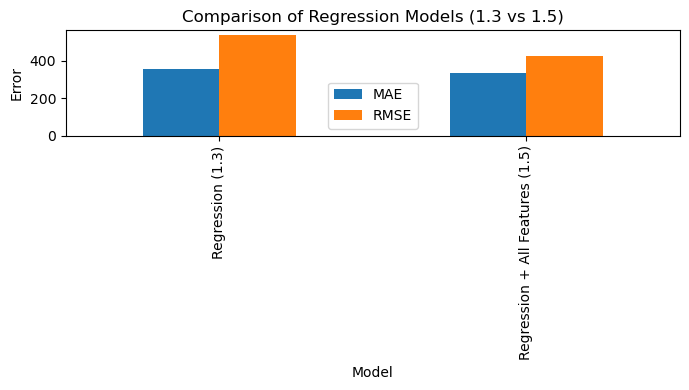

In [ ]:
# ======================================
# Question 1.5 — Step 3: Model Comparison
# ======================================

import pandas as pd

# Giả sử bạn có các giá trị đã in trước đó từ hai mô hình:
# Model 1: regression cơ bản (Question 1.3)
mae_basic = 356.18
rmse_basic = 536.78
r2_basic = -0.228

# Model 2: regression dùng tất cả features (Question 1.5)
mae_all = 336.29
rmse_all = 425.84
r2_all = 0.227

# Tạo bảng so sánh
compare_df = pd.DataFrame({
    "Model": ["Regression (1.3)", "Regression + All Features (1.5)"],
    "MAE": [mae_basic, mae_all],
    "RMSE": [rmse_basic, rmse_all],
    "R²": [r2_basic, r2_all]
})

print("✅ Step 3 completed — Comparison between models:\n")
display(compare_df)

# Visualization
compare_df.plot(x="Model", y=["MAE", "RMSE"], kind="bar", figsize=(7,4))
plt.title("Comparison of Regression Models (1.3 vs 1.5)")
plt.ylabel("Error")
plt.tight_layout()
plt.show()